In [5]:
import csv, os
import matplotlib.pyplot as plt
import mplcyberpunk
import numpy as np

def read_csv(dir, run, d=1):
    filename = os.path.join(dir, run, "logs.csv")
    stats = {
        "steps": [],
        "eps_ret": [],
        "eps_n": [],
     }     
    entries = ["total_norm", "total_loss", "max_rollout_depth", "rmean_im_episode_return"]
    inds = {}
    with open(filename, 'r') as file:
        csvreader = csv.reader((line.replace('\0','') for line in file))   
        max_rollout_depth_ind = -1
        for n, row in enumerate(csvreader):            
            if n == 0:
                for entry in entries:
                    if entry in row:
                        inds[entry] = row.index(entry)
                        stats[entry] = []
                continue            
            if len(row) > 0 and int(row[-1]) > 100:
                stats["steps"].append(int(row[2])/d)
                stats["eps_ret"].append(float(row[-2]))
                stats["eps_n"].append(row[-1])
                for entry in entries:
                    if entry in stats:
                        x = row[inds[entry]]
                        if entry == "total_norm":                                
                            x = x[x.find("(")+1:x.find(",")]
                        else:
                            x = float(x)
                        stats[entry].append(x)
    return stats

def simplify(stats, gap=100000):
    ind = 0
    new_stats = {k:[] for k in stats.keys()}
    for n, step in enumerate(stats["steps"]):
        if step > ind:
            for k in stats.keys():
                new_stats[k].append(stats[k][n])
            ind += gap
    return new_stats
    
def mv(a, n=1000) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n    

def plot(all_stats, y="eps_ret", plot_dict=None, baseline=0, mv_avg=20, xlim=int(1e8), style=None, figsize=(24,8)):
    plt.style.use("default" if style is None else style)    
    rotate_n = 10 if style is None else 6
    
    if plot_dict is None: plot_dict = {k:k for k in all_stats.keys()}
    
    linestyles=["solid", "dashed", "dotted","dashdot"]
    f, ax = plt.subplots(1, 1, figsize=figsize)
    n = 0    
    for run, label in plot_dict.items():
        xs = all_stats[run]["steps"]
        if y not in all_stats[run]: continue
        ys = all_stats[run][y]
        bound = np.nonzero(np.array(xs) > xlim)[0]
        if len(bound) >= 1:
            xs = xs[:bound[0]]
            ys = ys[:bound[0]]
        ax.plot(np.array(xs[mv_avg-1:]), 
                mv(ys, n=mv_avg), 
                label=label, 
                linestyle=linestyles[(n//rotate_n)%4],
                linewidth=1)
        n += 1
        
    plt.xlim(0, xlim)    
    plt.xlabel("step")
    ylabels = {"rmean_im_episode_return" : "planning returns",
               "eps_ret": "real returns",
               "max_rollout_depth": "max search depth"}
    
    plt.ylabel(ylabels[y] if y in ylabels.keys() else y)
    
    if baseline == 1:
        plt.axhline(y=0.12, color='r', label="base policy", linewidth=1)
        plt.axhline(y=1.08, color='g', label="1-step exhaustive search", linewidth=1)
        plt.axhline(y=1.17, color='y', label="2-step exhaustive search", linewidth=1)
        plt.axhline(y=1.59, color='b', label="2-step 15-rollout search", linewidth=1)
        plt.axhline(y=1.50, color='c', label="20-simulations MCTS", linewidth=1)
    elif baseline == 2:
        plt.axhline(y=0.12, color='r', label="base policy", linewidth=1)
        plt.axhline(y=1.08, color='grey', label="1-step exhaustive search (5 steps)", linewidth=1)
        plt.axhline(y=1.81, color='darkgreen', label="2-step exhaustive search (30 steps)", linewidth=1)
        plt.axhline(y=2.14, color='navy', label="70-simulations MCTS (70 steps)", linewidth=1)        
        plt.axhline(y=2.31, color='purple', label="3-step exhaustive search  (155 steps)", linewidth=1)
        plt.axhline(y=2.66, color='plum', label="8-step 20-rollout search (160 steps)", linewidth=1)            
        plt.axhline(y=2.96, color='gold', label="4-step exhaustive search  (780 steps)", linewidth=1)
        #plt.axhline(y=2.96, color='c', label="4-step exhaustive search  (780 steps)", linewidth=1) 
    #plt.tight_layout() 
    plt.legend()
    if style == "cyberpunk": 
        mplcyberpunk.make_lines_glow()
    if style is None:
        plt.grid()
    plt.show()   
    
def download(dir, refresh=True, load=True):
    
    latest_runs = {"uk": "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_threscarry",
                   "cam": "alstm_3_1_rec_n_40_rei_aug2_clip_mem1_imcost_0.5_perfect_treecarry_threscarry",
                   "v1": "alstm_3_1_rec_n_60_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry",
                   "v4": "alstm_3_1_rec_n_40_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry",
                  }       
    if refresh:
        for server, lr in latest_runs.items():
            !mkdir $dir/$lr
            !scp $server:~/RS/thinker/logs/torchbeast/latest/*.* $dir/$lr    
    if load: return load_dir(dir)
    
def load_dir(dir):
    runs = os.listdir(dir)
    all_stats = {}
    mv_avg = 20
    for run in runs:
        if "past" == run: continue
        if "rei" in run:
            st = run.find("rec_n_")
            d = int(run[st+6:run.find("_", st+6)])
        else:
            d = 1  
        stats = simplify(read_csv(dir, run, d))
        all_stats[run] = stats
    return all_stats    

In [2]:
%matplotlib inline
#%matplotlib qt

mkdir: cannot create directory ‘/media/sc/datadisk/data/thinker/logs/planner_logs/alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_threscarry’: File exists
fields.csv                                    100%    0     0.0KB/s   00:00    
logs.csv                                      100% 7180KB 108.3MB/s   00:00    
meta.json                                     100% 6281    19.1MB/s   00:00    
model.tar                                     100% 4740KB 108.6MB/s   00:00    
out.log                                       100%  453     1.6MB/s   00:00    
mkdir: cannot create directory ‘/media/sc/datadisk/data/thinker/logs/planner_logs/alstm_3_1_rec_n_40_rei_aug2_clip_mem1_imcost_0.5_perfect_treecarry_threscarry’: File exists
fields.csv                                    100%    0     0.0KB/s   00:00    
logs.csv                                      100%  651KB   4.1MB/s   00:00    
meta.json                                     100% 5236   219.4KB/s   00:00    
model.tar               

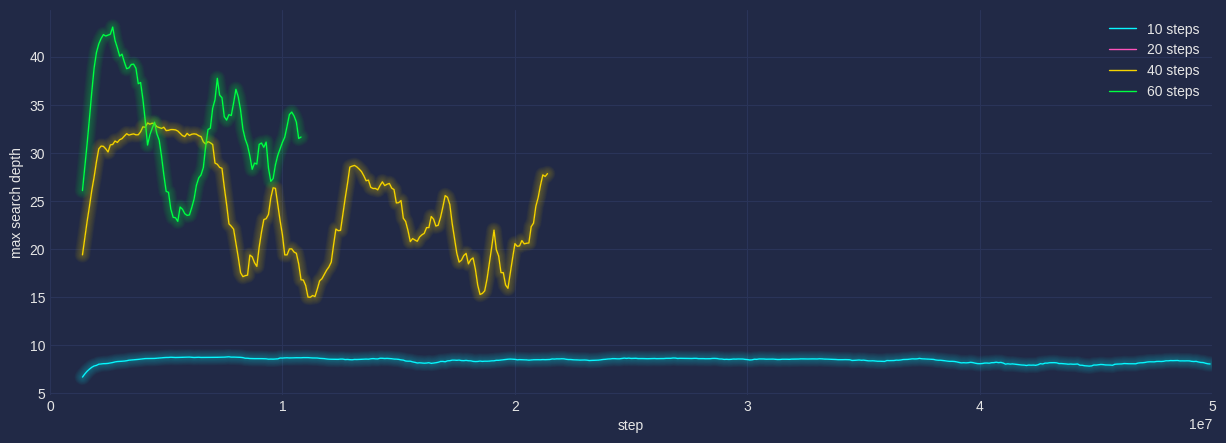

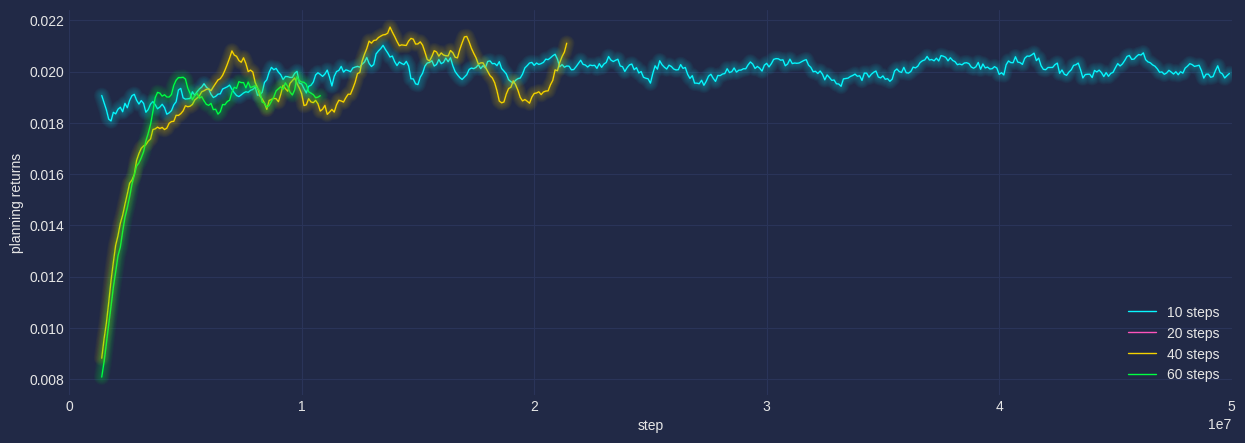

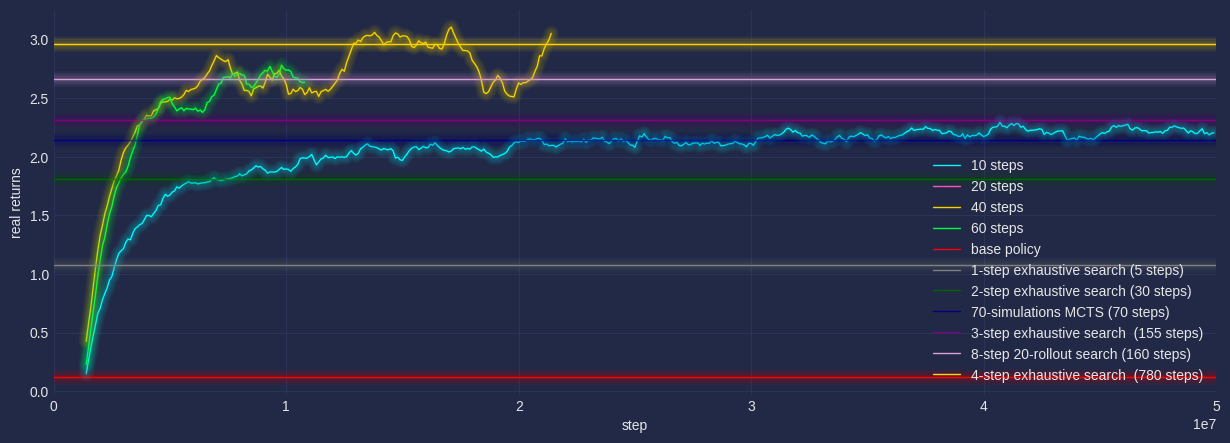

In [12]:
dir = "/media/sc/datadisk/data/thinker/logs/planner_logs"
all_stats = download(dir)
#all_stats = download(False, load=True)
#style = None
style = "cyberpunk"
figsize = (15, 5)

plot_dict = {
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem0_imcost_0_perfect": "imcost_0_mem_0",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0_perfect": "imcost_0",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.5_perfect": "imcost_0.5",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect": "imcost_1",   
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.25_perfect_largeclip": "imcost_0.25, largeclip",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.5_perfect_resetm_1_largeclip": "imcost_0.5, largeclip, resetm_1",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.5_perfect_resetm_1_nograd": "imcost_0.5, nograd, resetm_1, nograd",
   #"alstm_3_1_rec_n_40_rei_aug2_clip_mem1_imcost_0.1_perfect": "imcost_0.1 (40 steps)", 
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0_perfect_treecarry": "imcost_0 tree_carry",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry": "imcost_1 tree_carry",    
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "imcost_1 tree_carry off_policy_RR_carry",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_threscarry" : "off-policy RR carry",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry_resetm_3": "imcost_1 resetm_3 ttcarry",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem2.5_imcost_1_perfect_treecarry_threscarry": "imcost_1 mem_2.5 ttcarry",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem2_imcost_1_perfect_treecarry_threscarry_nograd": "nograd ttcarry", 
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry_rewardcarry": "ttrcarry",       
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_2_perfect_treecarry_threscarry": "imcost_2 ttcarry",    
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_tree_vb_-0.5": "vb -0.5", 
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_tree_vb_+0.5": "vb +0.5", 
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry_tree_vb_-0.5": "ttcarry vb-0.5",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry_tree_vb_+0.5": "ttcarry vb+0.5",   
   #"alstm_3_1_rec_n_20_rei_aug2_clip_mem1_imcost_0.25_perfect": "imcost_0.25 (20 steps)",
   #"alstm_3_1_rec_n_20_rei_aug2_clip_mem1_imcost_0.5_perfect": "imcost_0.5 (20 steps)",        
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "10 steps",
   "alstm_3_1_rec_n_20_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "20 steps",   
   "alstm_3_1_rec_n_40_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "40 steps",
   "alstm_3_1_rec_n_60_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "60 steps", 
   #"alstm_3_1_rec_n_20_rei_aug2_clip_mem1_imcost_0_perfect": "19 steps im_cost 0",   
}

plot(all_stats, "max_rollout_depth", plot_dict, baseline=0, mv_avg=15, xlim=int(5e7), style=style, figsize=figsize)
plot(all_stats, "rmean_im_episode_return", plot_dict, baseline=0, mv_avg=15, xlim=int(5e7), style=style, figsize=figsize)
plot(all_stats, "eps_ret", plot_dict, mv_avg=15, baseline=2, xlim=int(5e7), style=style, figsize=figsize)

In [ ]:
plot_dict = {"lstm_3_1_rec_n_5_w": "Backprop",
             "lstm_3_1_rec_n_5_gbste": "GB-STE",
             "lstm_3_1_rec_n_5_ste": "STE",
              "lstm_3_1_rec_n_5_rei": "REINFORCE",        
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"lstm_3_1_rec_n_5_gbste": "GB-STE",
             "lstm_3_1_rec_n_5_gbste_aug": "GB-STE w/ augmented stat.",
             "lstm_3_1_rec_n_5_rei": "REINFORCE",        
             "lstm_3_1_rec_n_5_rei_aug": "REINFORCE w/ augmented stat.",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"lstm_3_1_rec_n_5_gbste": "LSTM",
             "tran_3_1_rec_n_5_gbste_aug": "Transformer",        
             "alstm_3_1_rec_n_5_gbste_aug": "LSTM w/ attn. (4 steps)",
             "alstm_3_1_rec_n_10_gbste_aug": "LSTM w/ attn. (9 steps)",          
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"lstm_3_1_rec_n_5_gbste": "LSTM_3_1",
             "tran_3_1_rec_n_5_gbste_aug": "Transformer",        
             "alstm_3_1_rec_n_5_gbste_aug": "ALSTM_3_1 (4 steps)",
             "alstm_3_1_rec_n_10_gbste_aug": "ALSTM_3_1 (9 steps)",             
             "alstm_3_1_rec_n_5_gbste_aug_clip": "ALSTM_3_1 (4 steps; clipped)",             
             "alstm_3_1_rec_n_10_gbste_aug_clip": "ALSTM_3_1 (9 steps; clipped)",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"alstm_3_1_rec_n_1_gbste_aug_clip": "ALSTM_3_1 (0 steps; clipped)",             
             "alstm_3_1_rec_n_2_gbste_aug_clip": "ALSTM_3_1 (1 steps; clipped)",                     
             "alstm_3_1_rec_n_5_gbste_aug_clip": "ALSTM_3_1 (4 steps; clipped)",             
             "alstm_3_1_rec_n_10_gbste_aug_clip": "ALSTM_3_1 (9 steps; clipped)",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"alstm_3_1_rec_n_1_gbste_aug_clip": "ALSTM_3_1 (0 steps)",                  
             "alstm_3_1_rec_n_5_gbste_aug_clip": "ALSTM_3_1 (4 steps)",                          
             "alstm_3_1_rec_n_10_gbste_aug_clip": "ALSTM_3_1 (9 steps)",    
             "alstm_3_1_rec_n_1_gbste_aug_clip_realnomem": "ALSTM_3_1 (0 steps; no mem.)",                  
             "alstm_3_1_rec_n_5_gbste_aug_clip_realnomem": "ALSTM_3_1 (4 steps; no mem.)",                          
             "alstm_3_1_rec_n_10_gbste_aug_clip_realnomem": "ALSTM_3_1 (9 steps; no mem.)",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {
             "alstm_3_1_rec_n_1_gbste_aug_clip": "ALSTM_3_1 (0 steps; clipped)",
             "alstm_3_1_rec_n_5_gbste_aug_clip": "ALSTM_3_1 (4 steps; clipped)",             
             "alstm_3_1_rec_n_10_gbste_aug_clip": "ALSTM_3_1 (9 steps; clipped)",
             "alstm_3_1_rec_n_1_gbste_aug_clip_realnomem": "ALSTM_3_1 (0 steps; clipped; real_no_mem)",
             "alstm_3_1_rec_n_5_gbste_aug_clip_realnomem": "ALSTM_3_1 (4 steps; clipped; real_no_mem)",
             "alstm_3_1_rec_n_10_gbste_aug_clip_realnomem": "ALSTM_3_1 (9 steps; clipped; real_no_mem)",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {#"alstm_3_1_rec_n_1_rei_aug_clip_realnomem": "ALSTM_3_1 (0 steps; clipped; real_no_mem)",
             "alstm_3_1_rec_n_5_rei_aug_clip_realnomem": "4 steps; REINFORCE",
             "alstm_3_1_rec_n_10_rei_aug_clip_realnomem": "9 steps; REINFORCE", 
             #"alstm_3_1_rec_n_1_gbste_aug_clip_realnomem": "ALSTM_3_1 (0 steps; no mem.)",                  
             "alstm_3_1_rec_n_5_gbste_aug_clip_realnomem": "4 steps; GB-STE",                          
             "alstm_3_1_rec_n_10_gbste_aug_clip_realnomem": "9 steps; GB-STE",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"alstm_3_1_rec_n_10_rei_clip_realnomem": "Stat type 1", 
             "alstm_3_1_rec_n_10_rei_aug_clip_realnomem": "Stat type 2", 
             "alstm_3_1_rec_n_10_rei_aug2_clip_mem0": "Stat type 3", 
             "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0": "Stat type 3 (with real mem)",  
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(5e7))

plot_dict = {
             "alstm_3_1_rec_n_10_rei_aug2_clip_mem0": "Stat type 3", 
             "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0": "Stat type 3 (with real mem)",  
            }
plot(all_stats, "max_rollout_depth", plot_dict, mv_avg=20, xlim=int(5e7))

plot_dict = {
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0": "im_cost=0",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.5": "im_cost=0.5",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1": "im_cost=1",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0_perfect": "im_cost=0 (perfect)",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.5_perfect": "im_cost=0.5 (perfect)",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect": "im_cost=1 (perfect)",    
   
}

plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(5e7))
plot(all_stats, "max_rollout_depth", plot_dict, mv_avg=20, xlim=int(5e7))